# Main

## Mount Google Drive, Link to folder & install requirements

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/IFT6756

/content/gdrive/MyDrive/IFT6756


In [3]:
!pip install -qr requirements.txt

     |████████████████████████████████| 81kB 4.8MB/s 


In [4]:
# # If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# # you can delete this cell which is specific to Google Colab. You may also
# # change the paths for data/logs in Arguments below.
# import sys
# import os
# import shutil
# import warnings

# folder = "/content/gdrive/MyDrive/IFT6756"
# !ln -Ts "$folder" /content/assignment 2> /dev/null

# # Add the assignment folder to Python path
# if '/content/assignment' not in sys.path:
#   sys.path.insert(0, '/content/assignment')

# # Install requirements
# !pip install -qr requirements.txt

## Imports

In [59]:
# Miscellaneous
%matplotlib inline
from typing import Tuple
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataclasses import dataclass

# My modules
from models import GAN, Autoencoder
from run_exp import train_autoencoder, train_gan
from utils import to_device, train_val_test_split, generate_samples, DWP

# Pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

# Check if CUDA is available
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

# Reproductibility 
torch.manual_seed(42)

## Arguments

In [6]:
@dataclass
class Arguments_gan:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  embedding_dim: int = 64
  random_dim: int = 100
  hidden_D: Tuple[int, ...] = (128, 64, 32)
  hidden_G: Tuple[int, ...] = (128, 256)

  # Optimization
  n_critic: int = 5
  clip_value: float = 0.01
  lr: float = 0.00005
  epochs: int = 200

  # Miscellaneous
  device: str = 'cpu'
  decoder = torch.load("/content/gdrive/MyDrive/IFT6756/saved_models/decoder.pt")
  verbose: bool = True


@dataclass
class Arguments_ae:
  # Data
  data_folder: str = '/content/gdrive/MyDrive/IFT6756/data'
  batch_size: int = 16

  # Model
  input_dim: int = 9
  latent_dim: int = 64
  hidden: Tuple[int, ...] = (9,16,32)

  # Optimization
  lr: float = 1e-3
  epochs: int = 50 

  # Miscellaneous
  device: str = 'cpu'


## Data

The features are

- NP: Number of household people
- HHT: Household or family type
- HINCP: Household income 
- HUPAC: Household presence and age of children 
- WIF: Workers in family during the last 12 months
- AGEP: Age of the person
- SEX: Gender of the person
- ESR: Employment status of the person 
- RAC1P: Recorded detailed race 


In [7]:
# Load data 
"""
# Uncomment this block to create train, val, test sets from the data
dfs = []
for i in range(1, 5):
  path = f'/content/gdrive/MyDrive/IFT6756/data/PUMA-120{i}-2012to2016-5%_Treated.csv'
  dfs.append(pd.read_csv(path))
df = pd.concat(dfs, axis=0, ignore_index=True)
train, val, test = train_val_test_split(df)
"""

# Load data 
train_df = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/train.csv', index_col=0)
val_df = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/val.csv', index_col=0)
test_df = pd.read_csv('/content/gdrive/MyDrive/IFT6756/data/TrainValTest/test.csv', index_col=0)
# To numpy arrays 
train = train_df.values
val = val_df.values
test = test_df.values
# To tensors
train_tensor = torch.tensor(train, dtype=torch.float32)
val_tensor = torch.tensor(val, dtype=torch.float32)
test_tensor = torch.tensor(test, dtype=torch.float32)

## Pretraining the decoder

### Initialization

In [ ]:
# # Experiment's details
# args = Arguments_ae(batch_size=16,
#                     input_dim=9,
#                     latent_dim=64,
#                     hidden=(9,16,32),
#                     lr=1e-3,
#                     epochs=50,
#                     device="cuda")

In [ ]:
# # DataLoader
# train_loader = DataLoader(train_tensor,
#                               batch_size=args.batch_size,
#                               shuffle=False)
# val_loader = DataLoader(val_tensor,
#                             batch_size=args.batch_size,
#                             shuffle=False)

In [ ]:
# # Model
# autoencoder = Autoencoder(args)
# print(autoencoder)

### Training

In [ ]:
# # Training
# optimizer = torch.optim.Adam(autoencoder.parameters(), lr=args.lr)
# train_autoencoder(autoencoder, train_loader, val_loader, optimizer, args)

### Visualization

In [ ]:
# # Plot validation and training losses
# epochs = range(1, args.epochs+1)
# plt.figure(figsize=(15, 7))
# plt.title("Mean square error (MSE) against the epochs for the training and validation set")
# plt.plot(epochs, autoencoder.logs["train loss"], label="training")
# plt.plot(epochs, autoencoder.logs["val loss"], label="validation")
# plt.xticks(epochs)
# plt.ylim((0, 50))
# plt.legend(loc=1)
# plt.show()

In [ ]:
# # Examples of reconstructions on validation set
# n = 10
# idx = random.sample(range(len(val)), n)
# for i in idx:
#   example = val_tensor[i].to(args.device)
#   print("\nTarget")
#   print(example)
#   print("Reconstruction")
#   print(autoencoder.decoder(autoencoder.encoder(example)))
#   print("Encoding")
#   print(autoencoder.encoder(example))


### Save decoder

In [ ]:
# torch.save(autoencoder.decoder, "/content/gdrive/MyDrive/IFT6756/saved_models/decoder.pt")

## Training WGAN

### Initialization

In [8]:
args = Arguments_gan(epochs=25, verbose=False)

In [9]:
# DataLoader
train_loader = DataLoader(train_tensor,
                              batch_size=args.batch_size,
                              shuffle=False)
val_loader = DataLoader(val_tensor,
                            batch_size=args.batch_size,
                            shuffle=False)

In [10]:
# Model
gan = GAN(args)
print(gan)

GAN(
  (G): Generator(
    (decoder): Decoder(
      (input_layer): Linear(in_features=64, out_features=32, bias=True)
      (layers): ModuleList(
        (0): Linear(in_features=32, out_features=16, bias=True)
        (1): Linear(in_features=16, out_features=9, bias=True)
      )
      (output_layer): Linear(in_features=9, out_features=9, bias=True)
      (relu): ReLU()
    )
    (input_layer): Linear(in_features=100, out_features=128, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
    )
    (output_layer): Linear(in_features=256, out_features=64, bias=True)
    (output_activation): Tanh()
  )
  (D): Discriminator(
    (input_layer): Linear(in_features=9, out_features=128, bias=True)
    (input_activation): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=32, bias=True)
   

### Training

In [11]:
optimizer_D = torch.optim.RMSprop(gan.D.parameters(), args.lr)
optimizer_G = torch.optim.RMSprop(gan.G.parameters(), args.lr)
train_gan(gan, train_loader, optimizer_D, optimizer_G, args)

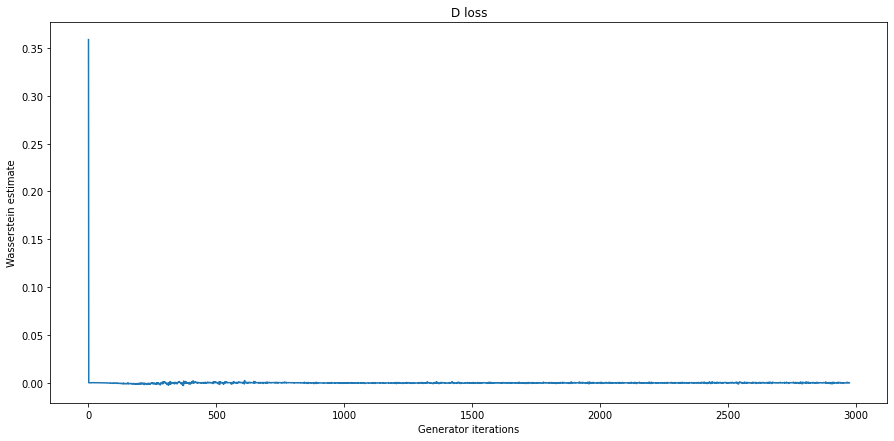

In [12]:
plt.figure(figsize=(15, 7))
plt.title("D loss")
plt.xlabel("Generator iterations")
plt.ylabel("Wasserstein estimate")
plt.plot(gan.logs["approx. EM distance"])
plt.show()

Looks like we are converging really fast...

## Model Evaluation

### Visual examples

In [15]:
batch_synthetic = generate_samples(gan.G, 25, args.random_dim)
print(batch_synthetic)

[[ 4.  5. 11.  0.  3.  2.  2.  2.  2.]
 [ 4.  7. 24.  0.  1.  2.  3.  3.  2.]
 [ 5.  1. 54.  0.  1.  1.  2.  4.  1.]
 [ 6.  7. 26.  0.  7.  2.  4.  3.  1.]
 [ 6.  4. 13.  0.  0.  2.  3.  2.  1.]
 [ 6.  6.  9.  3.  0.  2.  4.  2.  2.]
 [ 6.  4. 30.  3.  0.  2.  4.  4.  2.]
 [ 1.  2. 33.  0.  6.  1.  2.  2.  2.]
 [ 3.  5.  3.  0.  0.  2.  2.  1.  2.]
 [ 2.  2. 29.  1.  0.  1.  2.  2.  2.]
 [ 4.  3. 67.  6.  0.  1.  3.  3.  1.]
 [ 4.  7.  6.  0.  2.  2.  3.  2.  2.]
 [ 3.  6. 18.  0.  0.  2.  3.  2.  2.]
 [ 2.  5. 21.  2.  0.  2.  3.  2.  3.]
 [ 5.  5. 44.  6.  0.  1.  4.  3.  2.]
 [ 5.  5. 20.  5.  0.  2.  4.  3.  2.]
 [ 6.  7. 55.  2.  0.  1.  4.  2.  1.]
 [ 3.  2. 48.  0.  3.  1.  2.  2.  2.]
 [ 9.  3. 56.  2.  0.  1.  4.  5.  0.]
 [ 2.  3. 25.  0.  3.  1.  2.  2.  2.]
 [ 4.  5. 21.  0.  0.  2.  3.  2.  2.]
 [ 2.  2. 78.  0.  7.  1.  1.  3.  2.]
 [ 4.  4. 26.  5.  0.  2.  3.  3.  2.]
 [ 2.  5. 39. 10.  0.  2.  3.  2.  2.]
 [ 5.  3.  6.  2.  0.  2.  3.  2.  2.]]


### Compare the marginals

Generation of an equal number  of synthetic examples as in validation set

In [16]:
batch_synthetic = generate_samples(gan.G, val_df.shape[0], args.random_dim)
batch_synthetic_df = pd.DataFrame(batch_synthetic, columns=val_df.columns)

Some statistics for each dimension

In [17]:
val_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT
count,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000
mean,4.381199,3.580804,38.176659,1.640020,2.024673,1.500864,2.771527,2.881322,1.332346
std,1.279735,1.444155,22.861754,1.826899,2.268694,0.500061,0.826874,1.103919,0.708036
min,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,3.000000,2.000000,17.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000
50%,5.000000,3.000000,39.000000,1.000000,1.000000,2.000000,3.000000,3.000000,1.000000
75%,5.000000,4.000000,56.000000,1.000000,3.000000,2.000000,3.000000,4.000000,1.000000
max,6.000000,13.000000,94.000000,9.000000,6.000000,2.000000,4.000000,4.000000,3.000000


In [18]:
batch_synthetic_df.describe()

,HINCP,NP,AGEP,RAC1P,ESR,SEX,WIF,HUPAC,HHT
count,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000
mean,4.157661,3.793733,36.631386,1.855909,1.839625,1.413768,2.798914,2.805083,1.613373
std,1.899507,2.230963,22.866526,2.917886,2.574168,0.493073,0.930870,0.851229,0.585100
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,3.000000,2.000000,18.000000,0.000000,0.000000,1.000000,2.000000,2.000000,1.000000
50%,4.000000,4.000000,35.000000,0.000000,0.000000,1.000000,3.000000,3.000000,2.000000
75%,5.000000,5.000000,52.000000,3.000000,3.000000,2.000000,3.000000,3.000000,2.000000
max,12.000000,13.000000,137.000000,17.000000,11.000000,3.000000,7.000000,6.000000,4.000000


Visual comparison of each dimension's distribution using histograms.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


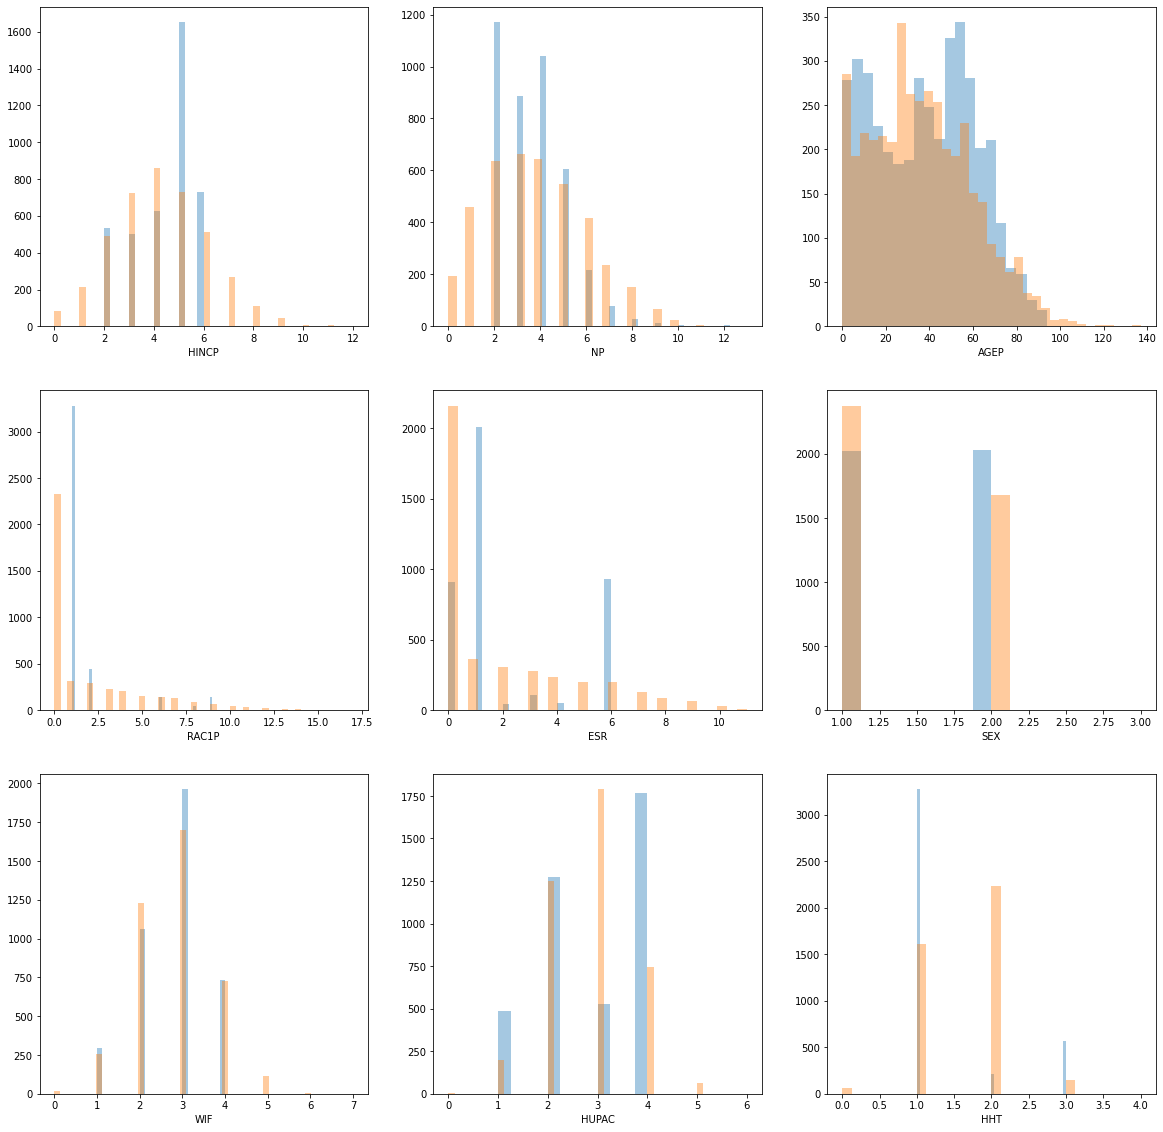

In [19]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))
k = 0
col = val_df.columns
for i in range(3):
  for j in range(3):
    sns.distplot(val_df[col[k]], kde=False, ax=ax[i, j])
    sns.distplot(batch_synthetic_df[col[k]], kde=False, ax=ax[i, j])
    k += 1

### Dimension-wise prediction

After training the model with real training dataset to generate synthetic population, we choose one dimension to be the label. The remaining dimensions are used as features to train two classifier with same hyperparameters to predict the isolated dimension. Then, we use the two classifiers to predict de test set. We can assume that the close the performance of the classifiers, the better the quality of the synthetic samples.
(https://arxiv.org/pdf/1703.06490.pdf)

In [46]:
# Generate synthetic train samples
train_synthetic = generate_samples(gan.G, train_df.shape[0], args.random_dim)
train_synthetic = pd.DataFrame(train_synthetic, columns=train_df.columns)

In [ ]:
f1_scores = []
for col in train_df.columns:
    f1_scores.append(DWP(train_df, train_synthetic, val_df, col))

In [75]:
for i, f1 in enumerate(f1_scores):
    f1_real, f1_synthetic = f1
    print(f"Dim:{train_df.columns[i]},\t F1 real: {f1_real:.3f},\t F1 synthetic: {f1_synthetic:.3f}")

Dim:HINCP,	 F1 real: 0.306,	 F1 synthetic: 0.309
Dim:NP,	 F1 real: 0.422,	 F1 synthetic: 0.251
Dim:AGEP,	 F1 real: 0.040,	 F1 synthetic: 0.014
Dim:RAC1P,	 F1 real: 0.726,	 F1 synthetic: 0.003
Dim:ESR,	 F1 real: 0.784,	 F1 synthetic: 0.083
Dim:SEX,	 F1 real: 0.537,	 F1 synthetic: 0.495
Dim:WIF,	 F1 real: 0.526,	 F1 synthetic: 0.450
Dim:HUPAC,	 F1 real: 0.630,	 F1 synthetic: 0.337
Dim:HHT,	 F1 real: 0.741,	 F1 synthetic: 0.548
